# 01.01 - PROYECTO KAGGLE

## download data directly from Kaggle

- create a file `kaggle.json` with your authentication token (in kaggle $\to$ click user icon on top-right $\to$ settings $\to$ API create new token)
- upload it to this notebook workspace
- run the following cell

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

udea-ai4eng-20242.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## unzip and inspect data

In [ ]:
!unzip udea*.zip > /dev/null

replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y

replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [{ENTER}]
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


## load `train.csv` data with pandas



In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
import unicodedata

In [ ]:
# Cargar los datos de entrenamiento y prueba
trainKaggle = pd.read_csv("train.csv")
testKaggle = pd.read_csv("test.csv")

## visualización de las columnas y algunos registros

# Preprocesado

In [ ]:
# Esta función normaliza las cadenas de texto eliminando acentos y convirtiendo a minúsculas
def normalize_string(s):
    return (
        unicodedata.normalize('NFKD', s)
        .encode('ascii', errors='ignore')
        .decode('utf-8')
        .lower()
        .strip()
        .replace('  ', ' ')
    )

In [ ]:
# Esta función extrae la primera palabra de un texto, eliminando ciertos caracteres
def extraer_primera_palabra(texto):
    palabra = texto.replace('3','')
    palabra = palabra.split()[0]
    palabra= palabra.replace('-','')
    return palabra

In [ ]:
# Diccionarios de mapeo: se usan para convertir las categorías de texto en valores numéricos
mapeo_rendimiento = {
    'bajo': 1,
    'medio-bajo': 2,
    'medio-alto': 3,
    'alto': 4
  }
map_matricula ={
    'Entre 5.5 millones y menos de 7 millones': 6,
    'Entre 2.5 millones y menos de 4 millones': 4,
    'Entre 4 millones y menos de 5.5 millones': 5,
    'Más de 7 millones': 7,
    'Entre 1 millón y menos de 2.5 millones': 3,
    'Entre 500 mil y menos de 1 millón': 2,
    'Menos de 500 mil': 1

  }
mapeo_horas = {
    '0': 0,
    'Menos de 10 horas': 1,
    'Entre 11 y 20 horas': 2,
    'Entre 21 y 30 horas': 3,
    'Más de 30 horas': 4
  }
mapeo_estracto = {
    'Estrato 3':3,
    'Estrato 4':4,
    'Estrato 5':5,
    'Estrato 2':2,
    'Estrato 1':1,
    'Estrato 6':6,
    'Sin Estrato':0
  }

mapeo_region = {
     'BOGOTÁ': 'BOGOTÁ',
    'ATLANTICO': 'Caribe',
    'SANTANDER': 'Andina',
    'ANTIOQUIA': 'Andina',
    'HUILA': 'Andina',
    'SUCRE': 'Caribe',
    'CAQUETA': 'Amazonia',
    'CUNDINAMARCA': 'Andina',
    'BOLIVAR': 'Caribe',
    'TOLIMA': 'Andina',
    'VALLE': 'Andina',
    'QUINDIO': 'Andina',
    'RISARALDA': 'Andina',
    'CORDOBA': 'Caribe',
    'META': 'Orinoquia',
    'LA GUAJIRA': 'Caribe',
    'BOYACA': 'Andina',
    'NARIÑO': 'Andina',
    'CAUCA': 'Andina',
    'NORTE SANTANDER': 'Andina',
    'CESAR': 'Caribe',
    'PUTUMAYO': 'Amazonia',
    'CALDAS': 'Andina',
    'MAGDALENA': 'Caribe',
    'CHOCO': 'Pacífico',
    'CASANARE': 'Orinoquia',
    'ARAUCA': 'Orinoquia',
    'GUAVIARE': 'Orinoquia',
    'AMAZONAS': 'Amazonia',
    'VAUPES': 'Amazonia',
    'SAN ANDRES': 'Insular',
    'VICHADA': 'Orinoquia'
  }

# Esta función aplica todo el preprocesamiento sobre los datos de entrada
def preprocess(dataframe):
  train = dataframe.copy()
  print("el shape inicial fue :")
  print(train.shape)
  target = 'RENDIMIENTO_GLOBAL'
  # Mapear la variable objetivo si existe en los datos
  if(target in train):
    train[target] = train[target].map(mapeo_rendimiento)

  # Normalizar y simplificar el nombre del programa académico
  train['ESTU_PRGM_ACADEMICO'] = train['ESTU_PRGM_ACADEMICO'].apply(normalize_string)
  train['ESTU_PRGM_ACADEMICO'] = train['ESTU_PRGM_ACADEMICO'].apply(extraer_primera_palabra)

  # Agrupar los 15 programas más comunes, el resto se marca como 'otra'
  frecuencia = train['ESTU_PRGM_ACADEMICO'].value_counts()
  top_10 = frecuencia.nlargest(15).index
  train['ESTU_PRGM_ACADEMICO'] = train['ESTU_PRGM_ACADEMICO'].apply(lambda x: x if x in top_10 else 'otra')

  # Aplicar mapeo a varias columnas
  train['ESTU_PRGM_DEPARTAMENTO'] = train['ESTU_PRGM_DEPARTAMENTO'].map(mapeo_region)
  train['FAMI_ESTRATOVIVIENDA'] = train['FAMI_ESTRATOVIVIENDA'].map(mapeo_estracto)
  train['ESTU_HORASSEMANATRABAJA'] = train['ESTU_HORASSEMANATRABAJA'].map(mapeo_horas)
  train["ESTU_VALORMATRICULAUNIVERSIDAD"] = train["ESTU_VALORMATRICULAUNIVERSIDAD"].map(map_matricula)

  # Imputación de valores faltantes en educación de padres
  modaPadre = train['FAMI_EDUCACIONMADRE'].mode()[0]
  modaMadre = train['FAMI_EDUCACIONPADRE'].mode()[0]
  train['FAMI_EDUCACIONMADRE'].fillna(modaMadre, inplace=True)
  train['FAMI_EDUCACIONPADRE'].fillna(modaPadre, inplace=True)

  # One-hot encoding en educación de padres y conexión a internet
  one_hot_encoded_p = pd.get_dummies(train['FAMI_EDUCACIONPADRE'], prefix='FAMI_EDUCACIONPADRE')
  train = pd.concat([train, one_hot_encoded_p], axis=1)
  train.drop('FAMI_EDUCACIONPADRE', axis=1, inplace=True)
  one_hot_encoded_m = pd.get_dummies(train['FAMI_EDUCACIONMADRE'], prefix='FAMI_EDUCACIONMADRE')
  train = pd.concat([train, one_hot_encoded_m], axis=1)
  train.drop('FAMI_EDUCACIONMADRE', axis=1, inplace=True)
  #imputar a fami tiene internet
  modaInternet = train['FAMI_TIENEINTERNET'].mode()[0]
  train['FAMI_TIENEINTERNET'].fillna(modaInternet, inplace=True)
  #one hot a fami tiene internet
  one_hot_encoded_p = pd.get_dummies(train['FAMI_TIENEINTERNET'], prefix='FAMI_TIENEINTERNET')
  train = pd.concat([train, one_hot_encoded_p], axis=1)
  train.drop('FAMI_TIENEINTERNET', axis=1, inplace=True)

  # Imputación de valores numéricos usando KNN
  chunk_size = 3000
  numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
  num_rows = train.shape[0]
  imputer = KNNImputer(n_neighbors=3)
  for start in range(0, num_rows, chunk_size):
    end = min(start + chunk_size, num_rows)
    train.iloc[start:end, train.columns.get_indexer(numerical_cols)] = imputer.fit_transform(
        train.iloc[start:end, train.columns.get_indexer(numerical_cols)].to_numpy())
  # Codificación de variables categóricas
  label_encoder = LabelEncoder()
  categorical_columns = train.select_dtypes(include=['object']).columns
  for col in categorical_columns:
    train[col] = label_encoder.fit_transform(train[col])


  print("el shape final fue :" )
  print(train.shape)
  return train

In [ ]:
# Aplicamos el preprocesamiento
trainPreprocesado = preprocess(trainKaggle)
testPreprocesado = preprocess(testKaggle)

el shape inicial fue :
(692500, 12)


<ipython-input-38-faa76d61001a>:98: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['FAMI_EDUCACIONMADRE'].fillna(modaMadre, inplace=True)
<ipython-input-38-faa76d61001a>:99: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

el shape final fue :
(692500, 35)
el shape inicial fue :
(296786, 12)


<ipython-input-38-faa76d61001a>:98: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['FAMI_EDUCACIONMADRE'].fillna(modaMadre, inplace=True)
<ipython-input-38-faa76d61001a>:99: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

el shape final fue :
(296786, 35)


# Modelo

In [ ]:
# Escalado de datos
scaler = StandardScaler()
X = trainPreprocesado.drop(columns=["RENDIMIENTO_GLOBAL"])
y = trainPreprocesado["RENDIMIENTO_GLOBAL"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Configuración del modelo de regresión logística con búsqueda de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'class_weight': ['balanced']
}

In [ ]:
grid_search = GridSearchCV(LogisticRegression(max_iter=200, random_state=0), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_

In [ ]:
# Validación cruzada para evaluar la estabilidad del modelo
cross_val_scores = cross_val_score(model, X_train, y_train, cv=5)
print("Precisión media con validación cruzada:", cross_val_scores.mean())

Precisión media con validación cruzada: 0.3705030084235861


In [ ]:
# Evaluación del modelo
accuracy = model.score(X_test, y_test)
print(f"Porcentaje de acierto del modelo: {accuracy * 100:.2f}%")

Porcentaje de acierto del modelo: 37.19%


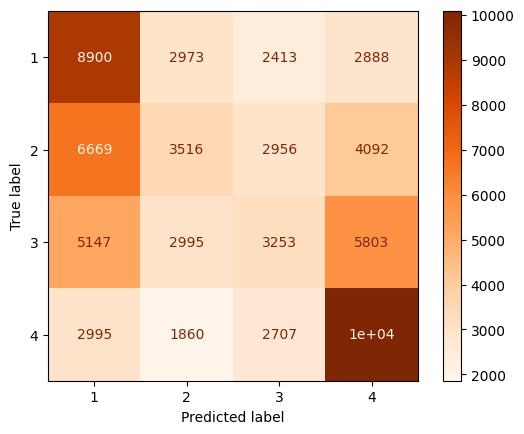

In [ ]:
# Visualización de la matriz de confusión
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Oranges)
plt.show()

# Envio a Kaggle

In [ ]:
# ENVÍO A KAGGLE
testPreprocesadoToSend = testPreprocesado.copy()
testPreprocesadoToSend.drop('Unnamed: 0', axis=1, inplace=True)
kagglePredictions = model.predict(testPreprocesadoToSend)
testPreprocesadoToSend['RENDIMIENTO_GLOBAL'] = kagglePredictions
envio = testPreprocesadoToSend[['ID','RENDIMIENTO_GLOBAL']]

# Mapeo inverso de los valores de rendimiento para el envío
mapeo_rendimiento = {
    1: 'bajo',
    2: 'medio-bajo',
    3: 'medio-alto',
    4: 'alto'
}
envio['RENDIMIENTO_GLOBAL'] = envio['RENDIMIENTO_GLOBAL'].map(mapeo_rendimiento)
envio.to_csv('submission.csv', index=False)
!kaggle competitions submit -c udea-ai4eng-20242 -f submission.csv -m "gradient boosting agrupando por nombre de carrera, region del pais + Bogotá "

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
<ipython-input-30-93c88ec2aa09>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  envio['RENDIMIENTO_GLOBAL'] = envio['RENDIMIENTO_GLOBAL'].map(mapeo_rendimiento)


100% 3.36M/3.36M [00:02<00:00, 1.37MB/s]
Successfully submitted to UDEA/ai4eng 20242 - Pruebas Saber Pro Colombia